In [3]:
include("eq1d_func.jl")
using NPZ
using Statistics
prefix = "/central/groups/esm/dzhuang/cost-accuracy-data/"


"/central/groups/esm/dzhuang/cost-accuracy-data/"

In [4]:
function plot_loss(data_analysis, n_data, downsample_ratio, n_fno_layers, k_max, d_f, epochs)
    plot_info = [n_data; downsample_ratio; n_fno_layers; k_max; d_f]
    n_tests, n_cols = size(data_analysis)
    i_row = 0
    for i = 1:n_tests
        if norm(data_analysis[i, 1:5] - plot_info) < 0.5
            i_row = i
            break
        end
    end
    
    n_train_repeat = div(n_cols-5-1, 3epochs)
    @info "i_row = ",i_row , data_analysis[i_row, 1:5] , plot_info, n_tests
    
    for i_train_repeat = 1:n_train_repeat
          
        PyPlot.semilogy(Array(1:epochs), data_analysis[i_row, 5+(i_train_repeat-1)*(3*epochs+1)+1:5+(i_train_repeat-1)*(3*epochs+1)+epochs], "--", label="training: "*string(plot_info))
        PyPlot.semilogy(Array(1:epochs), data_analysis[i_row, 5+(i_train_repeat-1)*(3*epochs+1)+epochs+1:5+(i_train_repeat-1)*(3*epochs+1)+2epochs], "-", label="test: "*string(plot_info))
    end
    
    PyPlot.legend()
end


function pareto_frontiers(data_analysis, fno_mean_rel_errors, fno_costs)
    n_tests = length(fno_costs)
    ind = Array(1:n_tests)
    data = [ind fno_mean_rel_errors fno_costs data_analysis]
    data = data[sortperm(data[:, 2]), :]
    
    for i=1:n_tests
        for j=1:i-1
            if data[i , 3] >= data[j , 3]
                data[i , 1] = -1
                break
            end
        end
    end
    
    data = data[data[:, 1] .> 0, :]
    
    data = data[sortperm(data[:, 1]), :]  
    return data
    
end

pareto_frontiers (generic function with 1 method)

# Darcy equation solver
$$-\nabla (a \nabla u) = f$$

In [ ]:
as = npzread(prefix*"darcy_a.npy")
us_ref = npzread(prefix*"darcy_u.npy")


Ne_ref = size(as, 2) - 1
Nes = [2^3; 2^4; 2^5; 2^6; 2^7; 2^8; 2^9; 2^10; 2^11]
Δxs = 1.0 ./ Nes

test_id = Array(1:10)
Ntest = length(test_id)
errors = zeros(length(Nes), Ntest)
rel_errors = zeros(length(Nes), Ntest)
for (i, Ne) in enumerate(Nes)
    f = 100*ones(Ne + 1)
    
    for j in test_id
        a  = as[j, 1:Int64(Ne_ref/Ne):end]
        u_ref = us_ref[j, 1:Int64(Ne_ref/Ne):end]
        
        u = solve_Darcy_1D(a, f)
        
        errors[i, j] = norm(u - u_ref)/sqrt(Ne)
        rel_errors[i, j] = norm(u - u_ref)/norm(u_ref)
    end
end

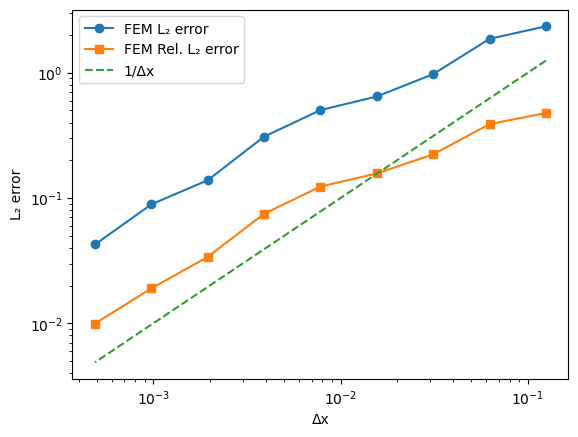

PyObject <matplotlib.legend.Legend object at 0x7f98b1dee290>

In [4]:
num_mean_errors = sum(errors, dims=2)/Ntest
num_mean_rel_errors = sum(rel_errors, dims=2)/Ntest
num_costs = 17*Nes
PyPlot.figure()
PyPlot.loglog(Δxs, num_mean_errors, "-o", label="FEM L₂ error")
PyPlot.loglog(Δxs, num_mean_rel_errors, "-s", label="FEM Rel. L₂ error")
PyPlot.loglog(Δxs, 10*Δxs.^1, "--", label="1/Δx")
PyPlot.xlabel("Δx")
PyPlot.ylabel("L₂ error")
PyPlot.legend()


# FNO results

In [5]:
n_data_array = [256 512 1024 2048 4096 8192 16384]
k_max_array = [16 32 64 128] 
d_f_array = [16 32 64 128]
n_fno_layers_array = [3 4 5]
downsample_ratio_array = [1 2 4 8]
       
epochs = 1001
n_train_repeat = 1

data_analysis = zeros(length(n_data_array)*length(downsample_ratio_array)*length(n_fno_layers_array)*length(k_max_array)*length(d_f_array), 5+(3*epochs+1)*n_train_repeat)
i_data_analysis = 0

for n_data in n_data_array
    for k_max in k_max_array
        for d_f in d_f_array
            for n_fno_layers in n_fno_layers_array
                for downsample_ratio in downsample_ratio_array
                    setup_info="n_data_"*string(n_data)*"_k_max_"*string(k_max)*"_downsample_ratio_"*string(downsample_ratio)*"_n_fno_layers_"*string(n_fno_layers)*"_d_f_"*string(d_f)
                    file_name = prefix*"data/darcy_analysis_"*setup_info*".npy"
                    i_data_analysis += 1
                    if isfile(file_name)
                        
                        data_analysis[i_data_analysis, :] = npzread(file_name)
                        
                    end
                end
            end
        end
    end
end
data_analysis = data_analysis[1:i_data_analysis, :]

#data_analysis[i_data_analysis,5+i_train_repeat*(3*epochs+1):5+(i_train_repeat+1)*(3*epochs+1)] 
# = np.hstack((train_rel_l2_losses, test_rel_l2_losses, test_l2_losses, cost))




1344×3009 Matrix{Float64}:
   256.0  1.0  3.0   16.0   16.0  …  0.132612   0.132733   2.01179e7
   256.0  2.0  3.0   16.0   16.0     0.134302   0.134371   9.35779e6
   256.0  4.0  3.0   16.0   16.0     0.141403   0.141385   4.33521e6
   256.0  8.0  3.0   16.0   16.0     0.159742   0.159715   2.00051e6
   256.0  1.0  4.0   16.0   16.0     0.117671   0.117696   2.59523e7
   256.0  2.0  4.0   16.0   16.0  …  0.119915   0.119893   1.20411e7
   256.0  4.0  4.0   16.0   16.0     0.131296   0.131293   5.56222e6
   256.0  8.0  4.0   16.0   16.0     0.152854   0.152867   2.55832e6
   256.0  1.0  5.0   16.0   16.0     0.119889   0.120001   3.17866e7
   256.0  2.0  5.0   16.0   16.0     0.123608   0.123627   1.47245e7
   256.0  4.0  5.0   16.0   16.0  …  0.133256   0.132958   6.78922e6
   256.0  8.0  5.0   16.0   16.0     0.153862   0.153779   3.11612e6
   256.0  1.0  3.0   16.0   32.0     0.112779   0.11288    4.46893e7
     ⋮                            ⋱                        
 16384.0  1.0  3

# Cost-accuracy tradeoff

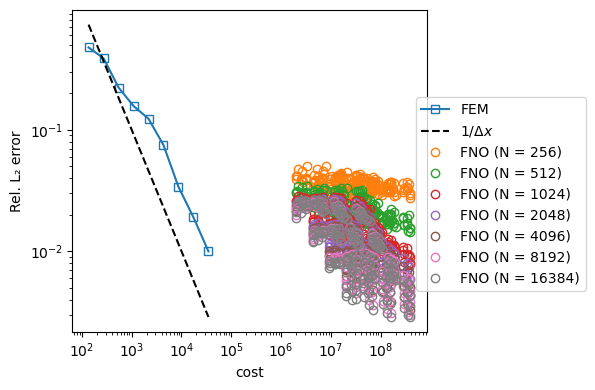

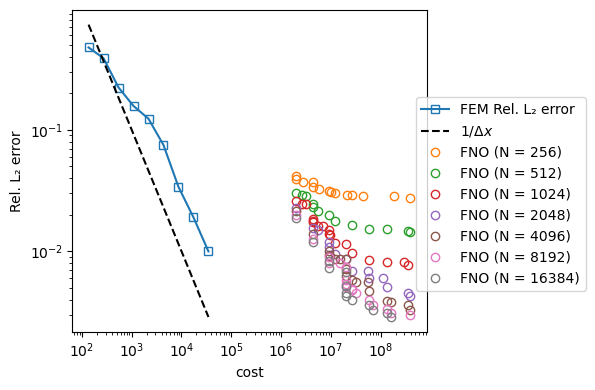

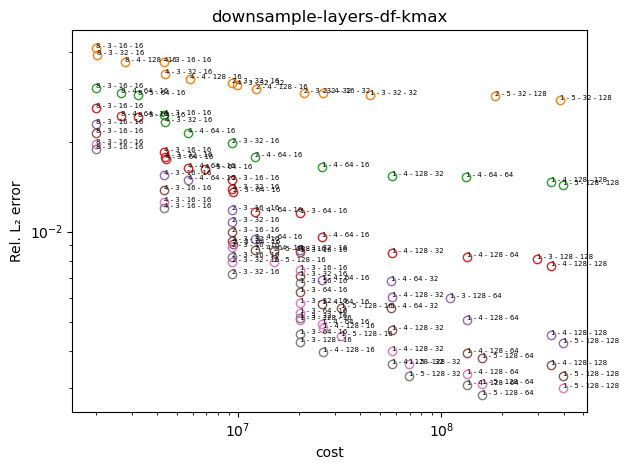

In [33]:
# Cost and error
fno_mean_errors = sum(data_analysis[:, (5+3*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_mean_rel_errors = sum(data_analysis[:, (5+2*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_mean_train_rel_errors = sum(data_analysis[:, (5+1*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat

fno_costs = data_analysis[:, end];

PyPlot.figure(figsize=(6,4))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM")
PyPlot.loglog(num_costs, 100.0./num_costs,       "--", color = "black", fillstyle = "none", label=L"$1/Δx$")

n_d = length(n_data_array)
n_g = div(length(fno_costs), n_d)
for i = 1:n_d
    # PyPlot.loglog(fno_costs[1+n_g*(i-1):n_g*i], fno_mean_errors[1+n_g*(i-1):n_g*i],     "-o", fillstyle = "none", label="FNO L₂ error")
    PyPlot.loglog(fno_costs[1+n_g*(i-1):n_g*i], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], "o", color = "C"*string(i), fillstyle = "none", label="FNO (N = $(n_data_array[i]))")
end

PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend(bbox_to_anchor=(0.95, 0.75))
PyPlot.tight_layout()
PyPlot.savefig("Darcy-cost-accuracy-raw.pdf")
##################################################

PyPlot.figure(figsize=(6,4))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM Rel. L₂ error")
PyPlot.loglog(num_costs, 100.0./num_costs,       "--", color = "black", fillstyle = "none", label=L"$1/Δx$")

for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_costs_pareto, fno_mean_rel_errors_pareto = data_analysis_pareto[:,3], data_analysis_pareto[:,2]
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto, "o", fillstyle = "none", color = "C"*string(i), label="FNO (N = $(n_data_array[i]))")

end
PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend(bbox_to_anchor=(0.95, 0.75))
PyPlot.tight_layout()
PyPlot.savefig("Darcy-cost-accuracy-pareto.pdf")
##################################################

PyPlot.figure()
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
# PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM Rel. L₂ error")
for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_costs_pareto, fno_mean_rel_errors_pareto = data_analysis_pareto[:,3], data_analysis_pareto[:,2]
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto, "o", fillstyle = "none", color = "C"*string(i), label="FNO (N = $(n_data_array[i]))")

    for i = 1:length(fno_costs_pareto)
        annotate = string(Int64(data_analysis_pareto[i, 5]))*" - "*string(Int64(data_analysis_pareto[i, 6]))*" - "*string(Int64(data_analysis_pareto[i, 7]))*" - "*string(Int64(data_analysis_pareto[i, 8]))
        PyPlot.annotate(annotate, (fno_costs_pareto[i], fno_mean_rel_errors_pareto[i]), fontsize=5)
    end
end
PyPlot.title("downsample-layers-df-kmax")
    

PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.tight_layout()
# PyPlot.legend()

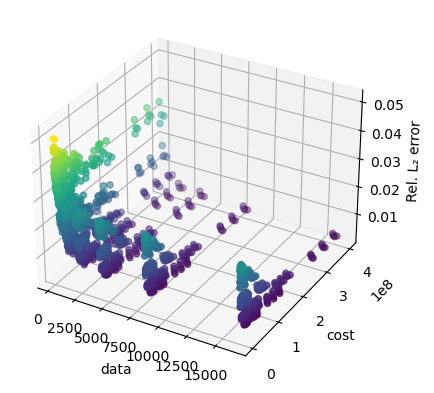

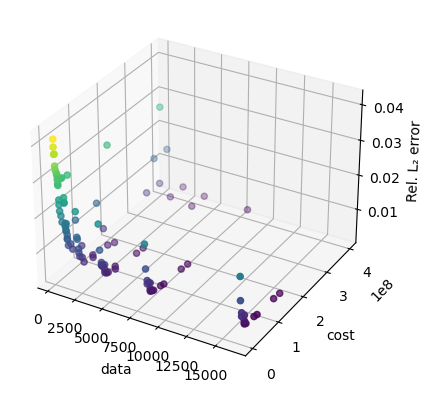

PyObject Text(0.10787434422876363, 0.014452421710067042, 'Rel. L₂ error')

In [34]:
# Cost/Data and error surface
# n_data, downsample_ratio, n_fno_layers, k_max, d_f
fno_data_size = data_analysis[:,1]
PyPlot.figure()
PyPlot.scatter3D(fno_data_size, fno_costs, fno_mean_rel_errors, c=fno_mean_rel_errors)
PyPlot.xlabel("data")
PyPlot.ylabel("cost")
PyPlot.zlabel("Rel. L₂ error")

###############################################################################
PyPlot.figure()
fno_data_size_pareto, fno_costs_pareto, fno_mean_rel_errors_pareto = [], [], []
for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_data_size_pareto = [fno_data_size_pareto;data_analysis_pareto[:,4]] 
    fno_costs_pareto = [fno_costs_pareto;data_analysis_pareto[:,3]]
    fno_mean_rel_errors_pareto = [fno_mean_rel_errors_pareto;data_analysis_pareto[:,2]]
    
end

PyPlot.scatter3D(fno_data_size_pareto, fno_costs_pareto, fno_mean_rel_errors_pareto, c=fno_mean_rel_errors_pareto)

PyPlot.xlabel("data")
PyPlot.ylabel("cost")
PyPlot.zlabel("Rel. L₂ error")


# regression 
# a/N^a' + b/C^b' = E

┌ Info: [24986.33715422016, 0.9834198540873081, 0.384070051299678, 0.5002099876692861]
└ @ Main In[35]:15


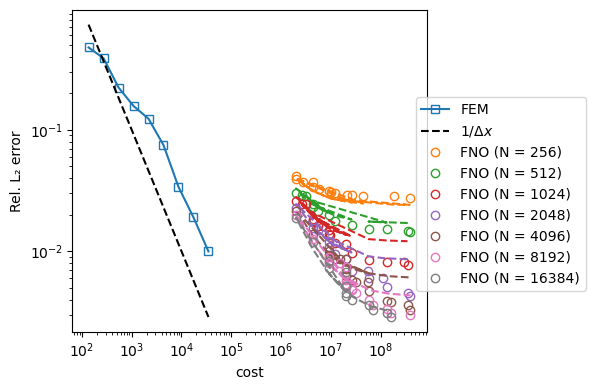

In [35]:
using LsqFit

# m(x, p) = p[1]./(x[:,1].^p[2])  +  p[3]./(x[:,2].^p[4])
# p0 = [1.0, 1.0, 1.0, 0.5]
# m(x, p) = (p[1]./(x[:,1].^p[2])  +  p[3]./(x[:,2].^min(p[4], 0.5))  +  p[5]./(x[:,1].^p[6].*x[:,2].^min(p[7], 0.5)) )
# p0 = [1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0]

m(x, p) = ( p[1]./(x[:,1].^p[2])  +  p[3]./(x[:,2].^min(p[4], 0.5))   )
p0 = [1.0, 1.0, 1.0, 0.4]


w = ones(length(fno_costs_pareto))
fit = curve_fit(m, [fno_costs_pareto fno_data_size_pareto fno_mean_rel_errors_pareto], fno_mean_rel_errors_pareto, w, p0)

@info fit.param

PyPlot.figure(figsize=(6,4))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM")
PyPlot.loglog(num_costs, 100.0./num_costs,       "--", color = "black", fillstyle = "none", label=L"$1/Δx$")

for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_costs_pareto, fno_mean_rel_errors_pareto, fno_data_size_pareto = data_analysis_pareto[:,3], data_analysis_pareto[:,2], data_analysis_pareto[:,4]
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto, "o", color = "C"*string(i), fillstyle = "none", label="FNO (N = $(n_data_array[i]))")
    
    fno_mean_rel_errors_pareto_fit = m([fno_costs_pareto fno_data_size_pareto], fit.param)
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto_fit, "--", color = "C"*string(i))
end
PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend(bbox_to_anchor=(0.95, 0.75))
PyPlot.tight_layout()
PyPlot.savefig("Darcy-cost-accuracy-fitting.pdf")

In [26]:
w = sqrt.(fno_data_size_pareto)

13-element Vector{Float64}:
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0
 128.0

In [10]:
fit.param


4-element Vector{Float64}:
 24986.33715422016
     0.9834198540873081
     0.384070051299678
     0.5002099876692861

In [11]:
?curve_fit

search: curve_fit



```
curve_fit(model, xdata, ydata, p0) -> fit
curve_fit(model, xdata, ydata, wt, p0) -> fit
```

Fit data to a non-linear `model`. `p0` is an initial model parameter guess (see Example), and `wt` is an optional array of weights. The return object is a composite type (`LsqFitResult`), with some interesting values:

  * `fit.resid` : residuals = vector of residuals
  * `fit.jacobian` : estimated Jacobian at solution

additionally, it is possible to query the degrees of freedom with

  * `dof(fit)`
  * `coef(fit)`

## Example

```julia
# a two-parameter exponential model
# x: array of independent variables
# p: array of model parameters
model(x, p) = p[1]*exp.(-x.*p[2])

# some example data
# xdata: independent variables
# ydata: dependent variable
xdata = range(0, stop=10, length=20)
ydata = model(xdata, [1.0 2.0]) + 0.01*randn(length(xdata))
p0 = [0.5, 0.5]

fit = curve_fit(model, xdata, ydata, p0)
```


In [ ]:
# Data and error
fno_data_size = data_analysis[:,1]
PyPlot.figure()
for i = 1: n_g
    # PyPlot.loglog(fno_data_size, fno_mean_errors, "o", label="FNO L₂ error")
    PyPlot.loglog(fno_data_size[i.+Array(0:n_d-1)*n_g], fno_mean_rel_errors[i.+Array(0:n_d-1)*n_g], "-o", fillstyle = "none")#, label="FNO Rel. L₂ error")
end
PyPlot.loglog(fno_data_size, 0.2./sqrt.(fno_data_size), "--", label=L"$1/\sqrt{N}$")

PyPlot.xlabel("data")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend()

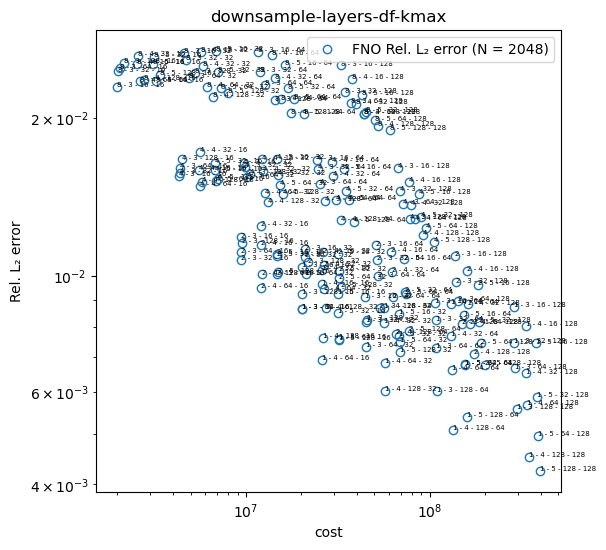

PyObject <matplotlib.legend.Legend object at 0x7f8c69510610>

In [9]:
PyPlot.figure(figsize=(6,6))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
# PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM Rel. L₂ error")

n_d = length(n_data_array)
n_g = div(length(fno_costs), n_d)
i = n_d - 2
fno_costs_nd, fno_mean_rel_errors_nd = fno_costs[1+n_g*(i-1):n_g*i], fno_mean_rel_errors[1+n_g*(i-1):n_g*i]
PyPlot.loglog(fno_costs_nd, fno_mean_rel_errors_nd, "o", fillstyle = "none", label="FNO Rel. L₂ error (N = $(n_data_array[i]))")

for i = 1: length(fno_costs_nd)
    annotate = string(Int64(data_analysis[i, 2]))*" - "*string(Int64(data_analysis[i, 3]))*" - "*string(Int64(data_analysis[i, 4]))*" - "*string(Int64(data_analysis[i, 5]))
    PyPlot.annotate(annotate, (fno_costs_nd[i], fno_mean_rel_errors_nd[i]), fontsize=5)
end
PyPlot.title("downsample-layers-df-kmax")
    

PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend()

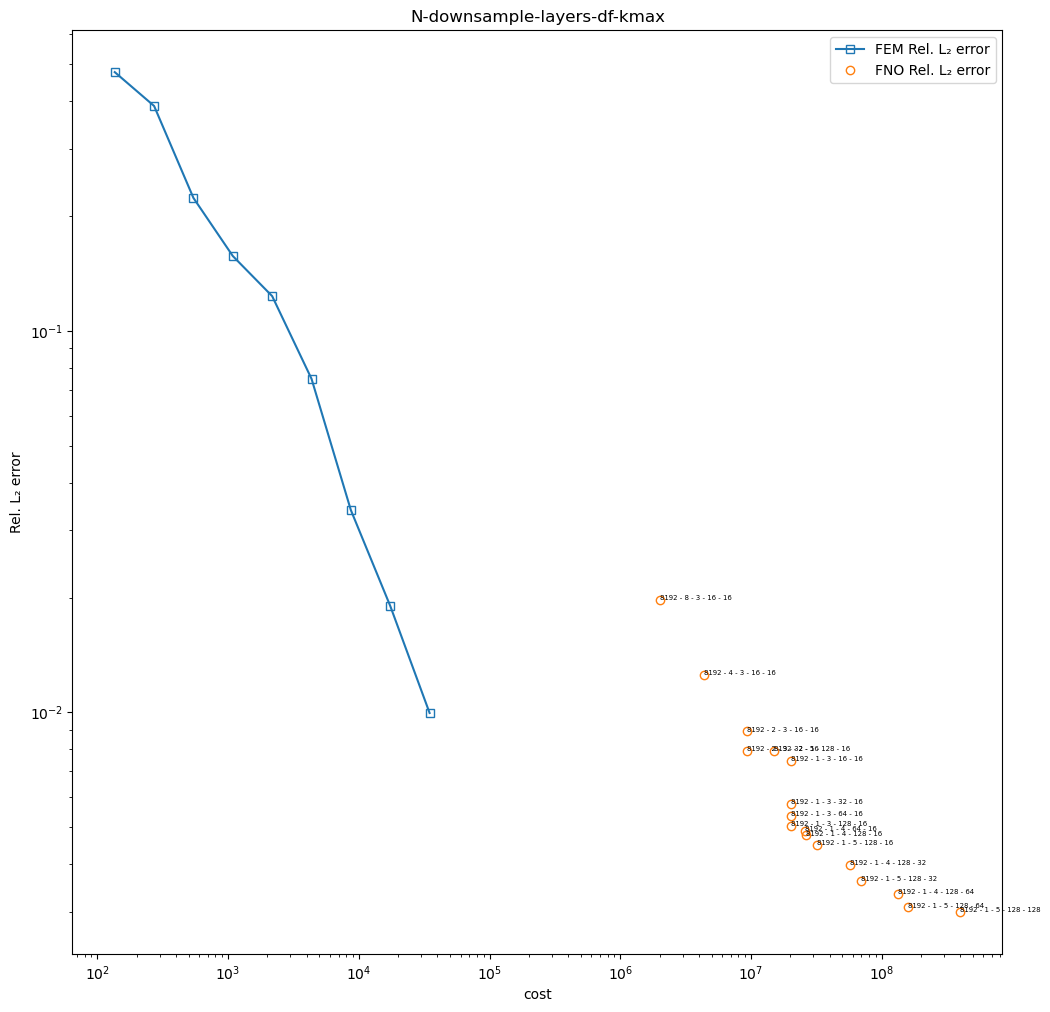

PyObject <matplotlib.legend.Legend object at 0x7f8c61ca8d10>

# Heat equation
$$
u_t - \triangle u = f
$$

In [5]:
u0s = npzread(prefix*"heat_u0.npy")
fs = npzread(prefix*"heat_f.npy")
us_ref = npzread(prefix*"heat_u.npy")

   
Ne_ref = 2^12
Nes = [2^4; 2^5; 2^6; 2^7; 2^8; 2^9; 2^10; 2^11;]
Δxs = 1.0 ./ Nes
T = 1.0/8
test_id = Array(1:10)
Ntest = length(test_id)
errors = zeros(length(Nes), Ntest)
rel_errors = zeros(length(Nes), Ntest)



for (i, Ne) in enumerate(Nes)
    
    Δt = 1/Ne
    Nt = Int64(T/Δt)
    
    for j in test_id
        u0  = u0s[j, 1:Int64(Ne_ref/Ne):end]
        u_ref = us_ref[j, 1:Int64(Ne_ref/Ne):end]
        f = fs[j, 1:Int64(Ne_ref/Ne):end]
        
        u = solve_heat_1D(u0, f, Δt, Nt)
        
        errors[i, j] = norm(u - u_ref)/sqrt(Ne)
        rel_errors[i, j] = norm(u - u_ref)/norm(u_ref)
    end
end




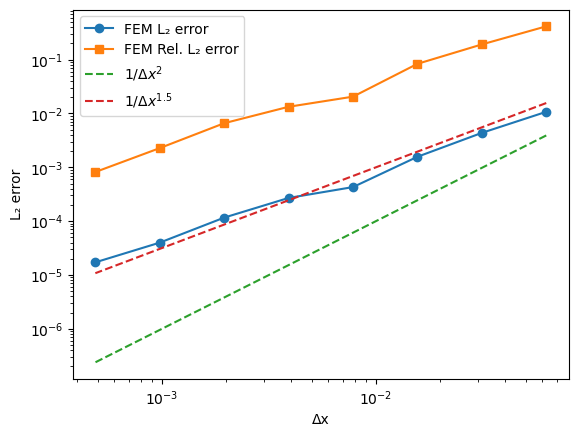

PyObject <matplotlib.legend.Legend object at 0x7f2319cfec50>

In [6]:
num_mean_errors = sum(errors, dims=2)/Ntest
num_mean_rel_errors = sum(rel_errors, dims=2)/Ntest
num_costs = 2*Nes/8*15 .* Nes
PyPlot.figure()
PyPlot.loglog(Δxs, num_mean_errors, "-o", label="FEM L₂ error")
PyPlot.loglog(Δxs, num_mean_rel_errors, "-s", label="FEM Rel. L₂ error")
PyPlot.loglog(Δxs, Δxs.^2, "--", label=L"$1/Δx^2$")
PyPlot.loglog(Δxs, Δxs.^1.5, "--", label=L"$1/Δx^{1.5}$")

PyPlot.xlabel("Δx")
PyPlot.ylabel("L₂ error")
PyPlot.legend()




# FNO results

In [7]:
n_data_array = [64 128 256 512 1024 2048 4096 8192 16384]
k_max_array = [16 32 64 128] 
d_f_array = [16 32 64 128]
n_fno_layers_array = [3 4 5]
downsample_ratio_array = [1 2 4 8]
       
epochs = 1001
n_train_repeat = 1

data_analysis = zeros(length(n_data_array)*length(downsample_ratio_array)*length(n_fno_layers_array)*length(k_max_array)*length(d_f_array), 5+(3*epochs+1)*n_train_repeat)
i_data_analysis = 0

for n_data in n_data_array
    for k_max in k_max_array
        for d_f in d_f_array
            for n_fno_layers in n_fno_layers_array
                for downsample_ratio in downsample_ratio_array
                    setup_info="n_data_"*string(n_data)*"_k_max_"*string(k_max)*"_downsample_ratio_"*string(downsample_ratio)*"_n_fno_layers_"*string(n_fno_layers)*"_d_f_"*string(d_f)
                    file_name = prefix*"data/heat_analysis_"*setup_info*".npy"
                    i_data_analysis += 1
                    if isfile(file_name)
                        
                        data_analysis[i_data_analysis, :] = npzread(file_name)
                        
                    end
                end
            end
        end
    end
end
data_analysis = data_analysis[1:i_data_analysis, :]

#data_analysis[i_data_analysis,5+i_train_repeat*(3*epochs+1):5+(i_train_repeat+1)*(3*epochs+1)] 
# = np.hstack((train_rel_l2_losses, test_rel_l2_losses, test_l2_losses, cost))




1728×3009 Matrix{Float64}:
    64.0  1.0  3.0   16.0   16.0  …  0.00324884   0.00324866   2.02556e7
    64.0  2.0  3.0   16.0   16.0     0.00319614   0.00319595   9.42663e6
    64.0  4.0  3.0   16.0   16.0     0.00320361   0.00320342   4.36965e6
    64.0  8.0  3.0   16.0   16.0     0.0032       0.0031998    2.01773e6
    64.0  1.0  4.0   16.0   16.0     0.00369194   0.00369177   2.60899e7
    64.0  2.0  4.0   16.0   16.0  …  0.00371248   0.0037123    1.211e7
    64.0  4.0  4.0   16.0   16.0     0.00369243   0.00369225   5.59665e6
    64.0  8.0  4.0   16.0   16.0     0.00366914   0.00366895   2.57553e6
    64.0  1.0  5.0   16.0   16.0     0.00306803   0.00306793   3.19242e7
    64.0  2.0  5.0   16.0   16.0     0.00298923   0.00298913   1.47933e7
    64.0  4.0  5.0   16.0   16.0  …  0.00299089   0.00299079   6.82365e6
    64.0  8.0  5.0   16.0   16.0     0.0029814    0.0029813    3.13333e6
    64.0  1.0  3.0   16.0   32.0     0.00243227   0.0024322    4.49645e7
     ⋮                    

# Cost-accuracy tradeoff

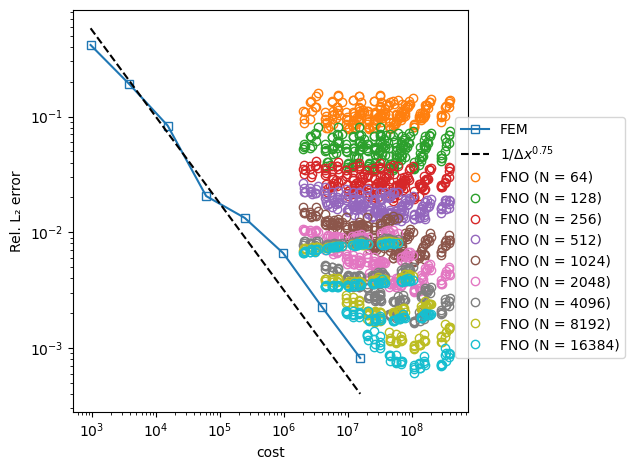

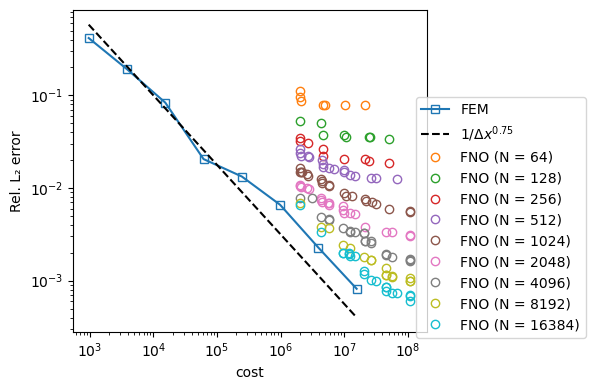

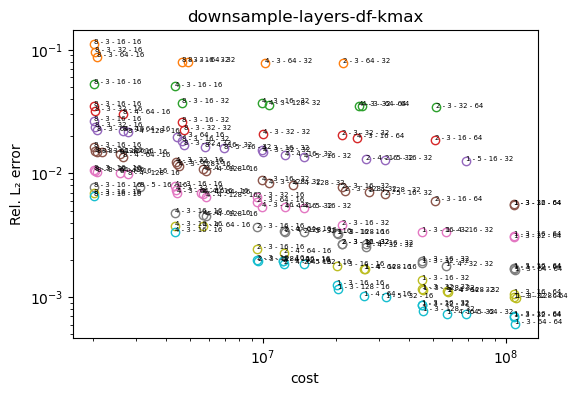

PyObject Text(24.000000000000007, 0.5, 'Rel. L₂ error')

In [9]:
# Cost and error
fno_mean_errors = sum(data_analysis[:, (5+3*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_mean_rel_errors = sum(data_analysis[:, (5+2*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_mean_train_rel_errors = sum(data_analysis[:, (5+1*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat

fno_costs = data_analysis[:, end];

PyPlot.figure()
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM")
PyPlot.loglog(num_costs, 100.0./(num_costs.^0.75),       "--", color = "black", fillstyle = "none", label=L"$1/Δx^{0.75}$")

n_d = length(n_data_array)
n_g = div(length(fno_costs), n_d)
for i = 1:n_d
    # PyPlot.loglog(fno_costs[1+n_g*(i-1):n_g*i], fno_mean_errors[1+n_g*(i-1):n_g*i],     "-o", fillstyle = "none", label="FNO L₂ error")
    PyPlot.loglog(fno_costs[1+n_g*(i-1):n_g*i], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], "o", fillstyle = "none", label="FNO (N = $(n_data_array[i]))")
end

PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend(bbox_to_anchor=(0.95, 0.75))
PyPlot.tight_layout()
PyPlot.savefig("Heat-cost-accuracy-raw.pdf")

##################################################

PyPlot.figure(figsize=(6,4))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM")
PyPlot.loglog(num_costs, 100.0./(num_costs.^0.75),       "--", color = "black", fillstyle = "none", label=L"$1/Δx^{0.75}$")

for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_costs_pareto, fno_mean_rel_errors_pareto = data_analysis_pareto[:,3], data_analysis_pareto[:,2]
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto, "o", fillstyle = "none", label="FNO (N = $(n_data_array[i]))")

end
PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend(bbox_to_anchor=(0.95, 0.75))
PyPlot.tight_layout()
PyPlot.savefig("Heat-cost-accuracy-pareto.pdf")

##################################################

PyPlot.figure(figsize=(6,4))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
# PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM Rel. L₂ error")
for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_costs_pareto, fno_mean_rel_errors_pareto = data_analysis_pareto[:,3], data_analysis_pareto[:,2]
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto, "o", fillstyle = "none", color = "C"*string(i), label="FNO (N = $(n_data_array[i]))")

    for i = 1:length(fno_costs_pareto)
        annotate = string(Int64(data_analysis_pareto[i, 5]))*" - "*string(Int64(data_analysis_pareto[i, 6]))*" - "*string(Int64(data_analysis_pareto[i, 7]))*" - "*string(Int64(data_analysis_pareto[i, 8]))
        PyPlot.annotate(annotate, (fno_costs_pareto[i], fno_mean_rel_errors_pareto[i]), fontsize=5)
    end
end
PyPlot.title("downsample-layers-df-kmax")
    

PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
# PyPlot.legend()







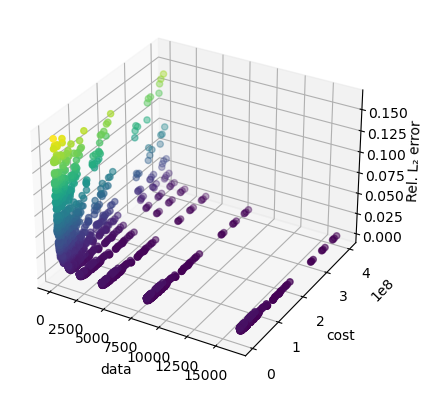

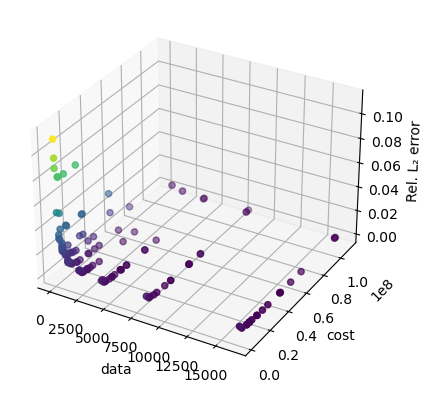

PyObject Text(0.10787434422876363, 0.014452421710067031, 'Rel. L₂ error')

In [20]:
# Cost/Data and error surface
# n_data, downsample_ratio, n_fno_layers, k_max, d_f
fno_data_size = data_analysis[:,1]
PyPlot.figure()
PyPlot.scatter3D(fno_data_size, fno_costs, fno_mean_rel_errors, c=fno_mean_rel_errors)
PyPlot.xlabel("data")
PyPlot.ylabel("cost")
PyPlot.zlabel("Rel. L₂ error")

###############################################################################
PyPlot.figure()
fno_data_size_pareto, fno_costs_pareto, fno_mean_rel_errors_pareto, data_size_pareto = [], [], [], []
for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_data_size_pareto = [fno_data_size_pareto;data_analysis_pareto[:,4]] 
    fno_costs_pareto = [fno_costs_pareto;data_analysis_pareto[:,3]]
    fno_mean_rel_errors_pareto = [fno_mean_rel_errors_pareto;data_analysis_pareto[:,2]]
    data_size_pareto = [data_size_pareto; zeros(length(data_analysis_pareto[:,2])) .+ n_data_array[i]]
end

PyPlot.scatter3D(fno_data_size_pareto, fno_costs_pareto, fno_mean_rel_errors_pareto, c=fno_mean_rel_errors_pareto)

PyPlot.xlabel("data")
PyPlot.ylabel("cost")
PyPlot.zlabel("Rel. L₂ error")


# regression 
# a/N^a' + b/C^b' = E

In [21]:
data_size_pareto

140-element Vector{Any}:
    64.0
    64.0
    64.0
    64.0
    64.0
    64.0
    64.0
   128.0
   128.0
   128.0
   128.0
   128.0
   128.0
     ⋮
 16384.0
 16384.0
 16384.0
 16384.0
 16384.0
 16384.0
 16384.0
 16384.0
 16384.0
 16384.0
 16384.0
 16384.0

┌ Info: [-122.84713783413774, 550.7864535423598, 0.31242805993896006, 0.5402643361527208]
└ @ Main In[22]:18


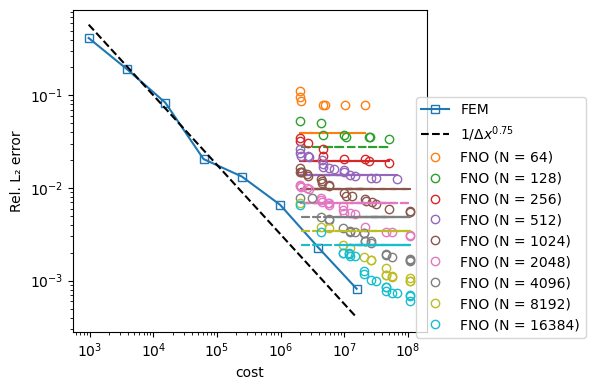

In [22]:
using LsqFit

# m(x, p) = p[1]./(x[:,1].^p[2])  +  p[3]./(x[:,2].^p[4])
# p0 = [1.0, 1.0, 1.0, 0.5]
# m(x, p) = (p[1]./(x[:,1].^p[2])  +  p[3]./(x[:,2].^min(p[4], 0.5))  +  p[5]./(x[:,1].^p[6].*x[:,2].^min(p[7], 0.5)) )
# p0 = [1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0]

m(x, p) = ( p[1]./(x[:,1].^p[2])  +  p[3]./(x[:,2].^min(p[4], 0.5))   )
# m(x, p) = ( p[1]./(x[:,1].^p[2])  +  p[3]./(x[:,2].^p[4])   )

p0 = [1.0, 1.0, 1.0, 0.4]


# w = ones(length(fno_costs_pareto))
w = data_size_pareto
fit = curve_fit(m, [fno_costs_pareto fno_data_size_pareto fno_mean_rel_errors_pareto], fno_mean_rel_errors_pareto, w, p0)

@info fit.param

PyPlot.figure(figsize=(6,4))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM")
PyPlot.loglog(num_costs, 100.0./(num_costs.^0.75),       "--", color = "black", fillstyle = "none", label=L"$1/Δx^{0.75}$")


for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_costs_pareto, fno_mean_rel_errors_pareto, fno_data_size_pareto = data_analysis_pareto[:,3], data_analysis_pareto[:,2], data_analysis_pareto[:,4]
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto, "o", color = "C"*string(i), fillstyle = "none", label="FNO (N = $(n_data_array[i]))")
    
    fno_mean_rel_errors_pareto_fit = m([fno_costs_pareto fno_data_size_pareto], fit.param)
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto_fit, "--", color = "C"*string(i))
end
PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend(bbox_to_anchor=(0.95, 0.75))
PyPlot.tight_layout()
PyPlot.savefig("Heat-cost-accuracy-fitting.pdf")


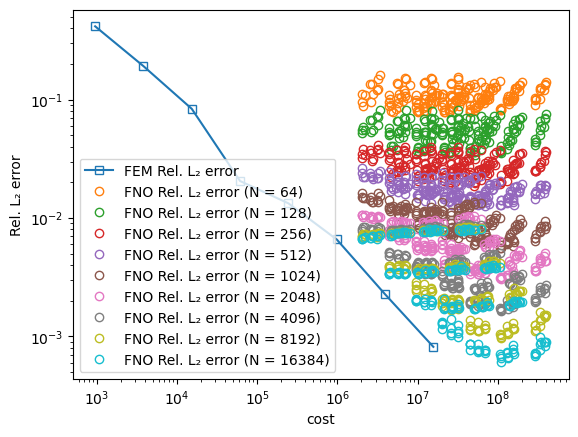

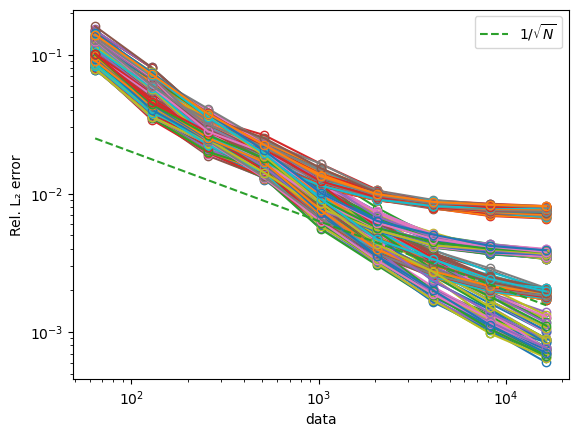

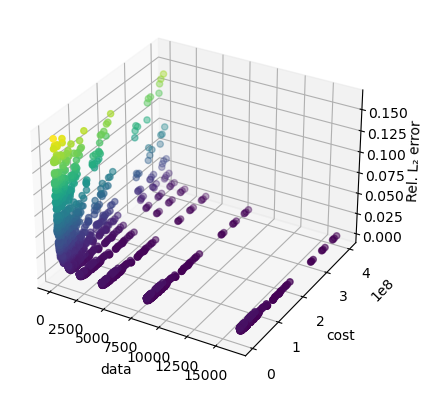

PyObject Text(0.10787434422876362, 0.01445242171006705, 'Rel. L₂ error')

In [17]:
# Cost and error
fno_mean_errors = sum(data_analysis[:, (5+3*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_mean_rel_errors = sum(data_analysis[:, (5+2*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_mean_train_rel_errors = sum(data_analysis[:, (5+1*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat

fno_costs = data_analysis[:, end];

PyPlot.figure()
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM Rel. L₂ error")

n_d = length(n_data_array)
n_g = div(length(fno_costs), n_d)
for i = 1:n_d
    # PyPlot.loglog(fno_costs[1+n_g*(i-1):n_g*i], fno_mean_errors[1+n_g*(i-1):n_g*i],     "-o", fillstyle = "none", label="FNO L₂ error")
    PyPlot.loglog(fno_costs[1+n_g*(i-1):n_g*i], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], "o", fillstyle = "none", label="FNO Rel. L₂ error (N = $(n_data_array[i]))")
end

PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend()


# Data and error
fno_data_size = data_analysis[:,1]
PyPlot.figure()
for i = 1: n_g
    # PyPlot.loglog(fno_data_size, fno_mean_errors, "o", label="FNO L₂ error")
    PyPlot.loglog(fno_data_size[i.+Array(0:n_d-1)*n_g], fno_mean_rel_errors[i.+Array(0:n_d-1)*n_g], "-o", fillstyle = "none")#, label="FNO Rel. L₂ error")
end
PyPlot.loglog(fno_data_size, 0.2./sqrt.(fno_data_size), "--", label=L"$1/\sqrt{N}$")

PyPlot.xlabel("data")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend()


# Cost/Data and error surface
# n_data, downsample_ratio, n_fno_layers, k_max, d_f
fno_data_size = data_analysis[:,1]
PyPlot.figure()
PyPlot.scatter3D(fno_data_size, fno_costs, fno_mean_rel_errors, c=fno_mean_rel_errors)
PyPlot.xlabel("data")
PyPlot.ylabel("cost")
PyPlot.zlabel("Rel. L₂ error")


# data fitting

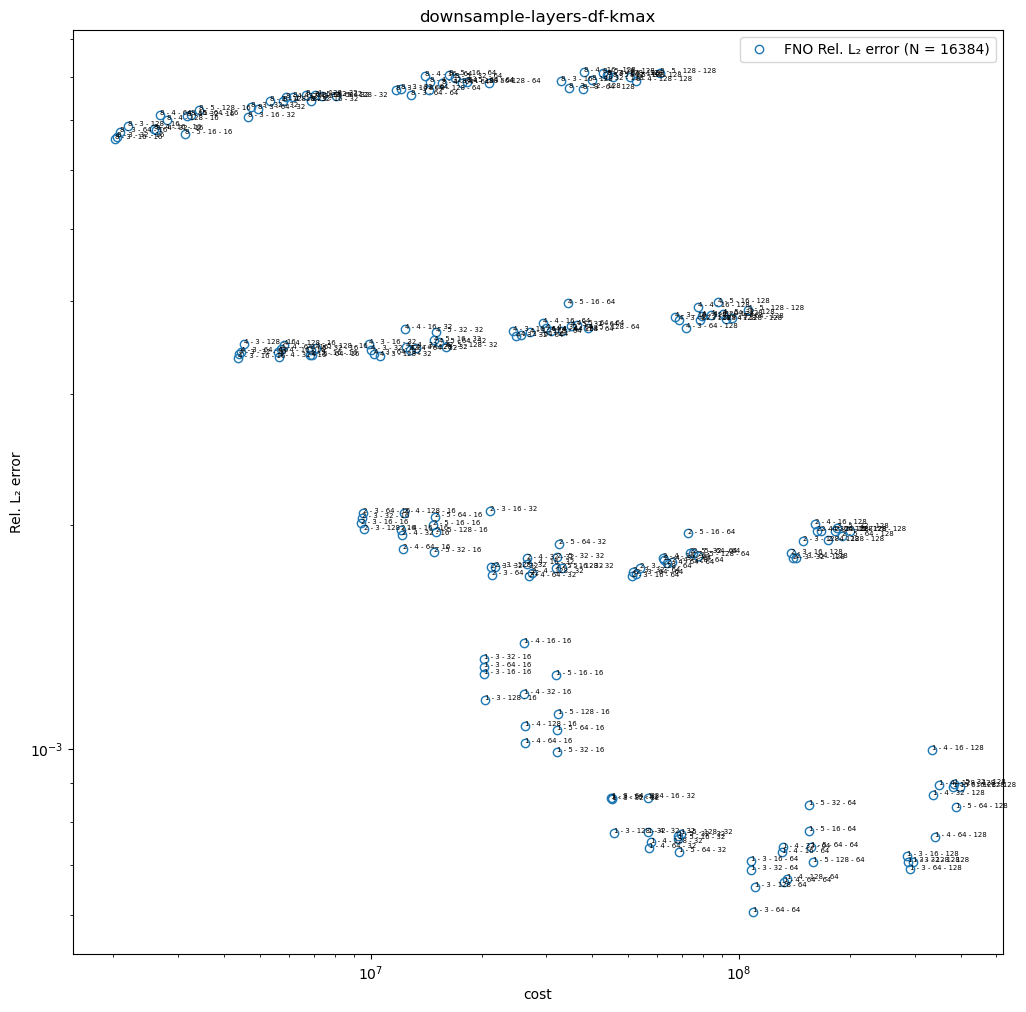

PyObject <matplotlib.legend.Legend object at 0x7fcc6dc809d0>

In [12]:
PyPlot.figure(figsize=(12,12))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
# PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM Rel. L₂ error")

n_d = length(n_data_array)
n_g = div(length(fno_costs), n_d)
i = n_d 
fno_costs_nd, fno_mean_rel_errors_nd = fno_costs[1+n_g*(i-1):n_g*i], fno_mean_rel_errors[1+n_g*(i-1):n_g*i]
PyPlot.loglog(fno_costs_nd, fno_mean_rel_errors_nd, "o", fillstyle = "none", label="FNO Rel. L₂ error (N = $(n_data_array[i]))")

for i = 1: length(fno_costs_nd)
    annotate = string(Int64(data_analysis[i, 2]))*" - "*string(Int64(data_analysis[i, 3]))*" - "*string(Int64(data_analysis[i, 4]))*" - "*string(Int64(data_analysis[i, 5]))
    PyPlot.annotate(annotate, (fno_costs_nd[i], fno_mean_rel_errors_nd[i]), fontsize=5)
end
PyPlot.title("downsample-layers-df-kmax")
    

PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend()

┌ Info: ("i_row = ", 1525, [8192.0, 1.0, 3.0, 128.0, 128.0], [8192, 1, 3, 128, 128], 1728)
└ @ Main In[2]:13
┌ Info: ("i_row = ", 1405, [8192.0, 1.0, 3.0, 32.0, 32.0], [8192, 1, 3, 32, 32], 1728)
└ @ Main In[2]:13


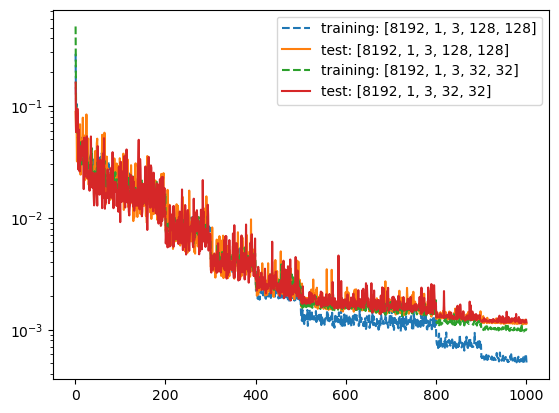

PyObject <matplotlib.legend.Legend object at 0x7fcc5972c290>

In [13]:
plot_loss(data_analysis, 8192, 1, 3, 128, 128, epochs)
plot_loss(data_analysis, 8192, 1, 3, 32, 32, epochs)

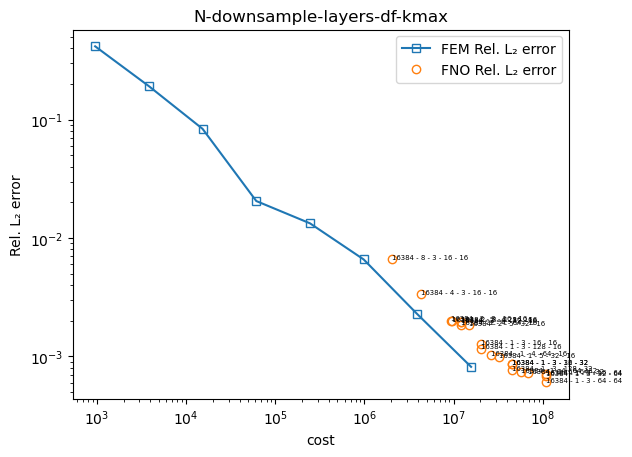

PyObject <matplotlib.legend.Legend object at 0x7fcc596015d0>

In [14]:
data_analysis_pareto = pareto_frontiers(data_analysis, fno_mean_rel_errors, fno_costs)

PyPlot.figure()
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "-s", fillstyle = "none", label="FEM Rel. L₂ error")

fno_costs_pareto, fno_mean_rel_errors_pareto = data_analysis_pareto[:,3], data_analysis_pareto[:,2]
PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto, "o", fillstyle = "none", label="FNO Rel. L₂ error")

for i = 1:length(fno_costs_pareto)
    annotate = string(Int64(data_analysis_pareto[i, 4]))*" - "*string(Int64(data_analysis_pareto[i, 5]))*" - "*string(Int64(data_analysis_pareto[i, 6]))*" - "*string(Int64(data_analysis_pareto[i, 7]))*" - "*string(Int64(data_analysis_pareto[i, 8]))
    PyPlot.annotate(annotate, (fno_costs_pareto[i], fno_mean_rel_errors_pareto[i]), fontsize=5)
end
PyPlot.title("N-downsample-layers-df-kmax")
    

PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend()

# Kuramoto–Sivashinsky Equation

In [18]:
rel_errors = npzread("KS_errors.npy") 
costs = npzread("KS_costs.npy")

num_costs = costs[:] 
num_mean_rel_errors = dropdims(mean(rel_errors, dims=1), dims=1)[2,:,:][:]
ind = num_mean_rel_errors .> 0
num_costs = num_costs[ind]
num_mean_rel_errors = num_mean_rel_errors[ind];

# FNO results

In [19]:
n_data_array = [64 128 256 512 1024 2048 4096 8192 16384]
k_max_array = [16 32 64 128] 
d_f_array = [16 32 64 128]
n_fno_layers_array = [3 4 5]
downsample_ratio_array = [1 2 4 8]
       
epochs = 1001
n_train_repeat = 1

data_analysis = zeros(length(n_data_array)*length(downsample_ratio_array)*length(n_fno_layers_array)*length(k_max_array)*length(d_f_array), 5+(3*epochs+1)*n_train_repeat)
i_data_analysis = 0

for n_data in n_data_array
    for k_max in k_max_array
        for d_f in d_f_array
            for n_fno_layers in n_fno_layers_array
                for downsample_ratio in downsample_ratio_array
                    setup_info="n_data_"*string(n_data)*"_k_max_"*string(k_max)*"_downsample_ratio_"*string(downsample_ratio)*"_n_fno_layers_"*string(n_fno_layers)*"_d_f_"*string(d_f)
                    file_name = prefix*"data/KS_analysis_"*setup_info*".npy"
                    i_data_analysis += 1
                    if isfile(file_name)
                        
                        data_analysis[i_data_analysis, :] = npzread(file_name)
                        
                    end
                end
            end
        end
    end
end
data_analysis = data_analysis[1:i_data_analysis, :]

#data_analysis[i_data_analysis,5+i_train_repeat*(3*epochs+1):5+(i_train_repeat+1)*(3*epochs+1)] 
# = np.hstack((train_rel_l2_losses, test_rel_l2_losses, test_l2_losses, cost))


1728×3009 Matrix{Float64}:
    64.0  1.0  3.0   16.0   16.0  0.227739  …  14.338    14.3382   9.35779e6
    64.0  2.0  3.0   16.0   16.0  0.226353     14.2935   14.2937   4.33521e6
    64.0  4.0  3.0   16.0   16.0  0.223659     14.2008   14.201    2.00051e6
    64.0  8.0  3.0   16.0   16.0  0.21857      14.1063   14.1065   9.22661e5
    64.0  1.0  4.0   16.0   16.0  0.216749     13.6047   13.605    1.20411e7
    64.0  2.0  4.0   16.0   16.0  0.215429  …  13.6371   13.6374   5.56222e6
    64.0  4.0  4.0   16.0   16.0  0.212863     13.5928   13.5931   2.55832e6
    64.0  8.0  4.0   16.0   16.0  0.208015     13.556    13.5563   1.1757e6
    64.0  1.0  5.0   16.0   16.0  0.211996     13.8308   13.8311   1.47245e7
    64.0  2.0  5.0   16.0   16.0  0.210709     13.9127   13.913    6.78922e6
    64.0  4.0  5.0   16.0   16.0  0.20821   …  13.9487   13.949    3.11612e6
    64.0  8.0  5.0   16.0   16.0  0.203485     13.9883   13.9886   1.42873e6
    64.0  1.0  3.0   16.0   32.0  0.211966     14.

# Cost Accuracy Trade-off

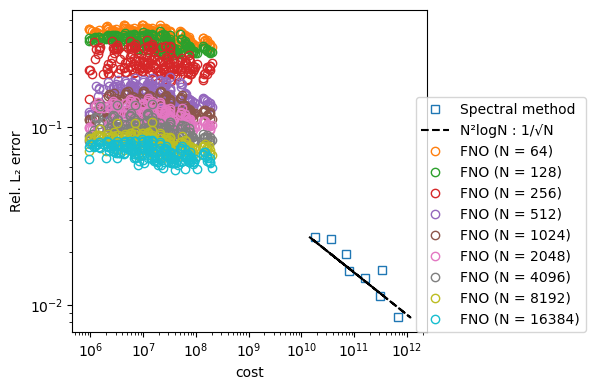

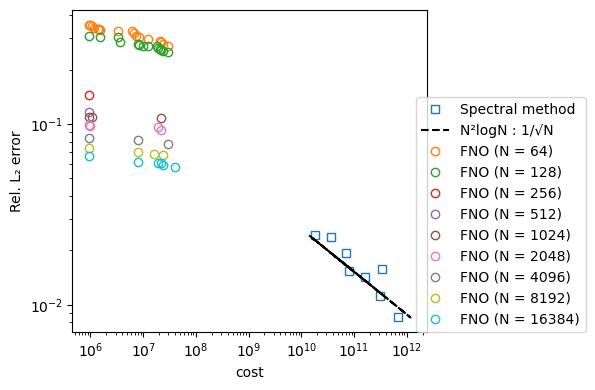

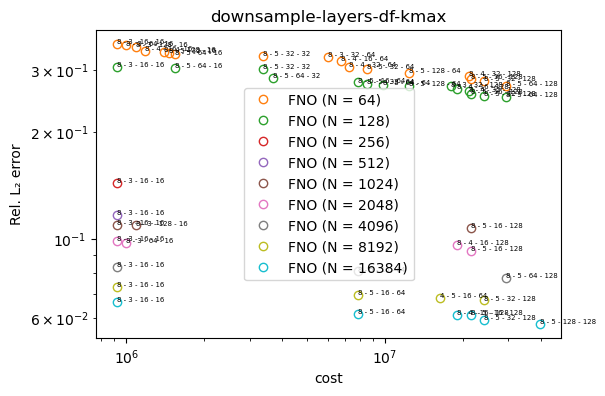

PyObject <matplotlib.legend.Legend object at 0x7fb447970f50>

In [23]:
# Cost and error


fno_mean_errors = sum(data_analysis[:, (5+3*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_mean_rel_errors = sum(data_analysis[:, (5+2*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_mean_train_rel_errors = sum(data_analysis[:, (5+1*epochs).+(3*epochs+1).*range(0,n_train_repeat-1)], dims=2)/n_train_repeat
fno_costs = data_analysis[:, end];

PyPlot.figure(figsize=(6,4))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "s", fillstyle = "none", label="Spectral method")
N_unit = (1.0 ./ num_mean_rel_errors).^2
PyPlot.loglog(650*N_unit.^2 .* log.(N_unit), num_mean_rel_errors, "--", color = "black", label="N²logN : 1/√N")



n_d = length(n_data_array)
n_g = div(length(fno_costs), n_d)
for i = 1:n_d
    # PyPlot.loglog(fno_costs[1+n_g*(i-1):n_g*i], fno_mean_errors[1+n_g*(i-1):n_g*i],     "-o", fillstyle = "none", label="FNO L₂ error")
    PyPlot.loglog(fno_costs[1+n_g*(i-1):n_g*i], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], "o", fillstyle = "none", label="FNO (N = $(n_data_array[i]))")
end

PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend(bbox_to_anchor=(0.95, 0.75))
PyPlot.tight_layout()
PyPlot.savefig("KS-cost-accuracy-raw.pdf")

# ##################################################

PyPlot.figure(figsize=(6,4))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "s", fillstyle = "none", label="Spectral method")
N_unit = (1.0 ./ num_mean_rel_errors).^2
PyPlot.loglog(650*N_unit.^2 .* log.(N_unit), num_mean_rel_errors, "--", color = "black", label="N²logN : 1/√N")

for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_costs_pareto, fno_mean_rel_errors_pareto = data_analysis_pareto[:,3], data_analysis_pareto[:,2]
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto, "o", fillstyle = "none", label="FNO (N = $(n_data_array[i]))")

end
PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend(bbox_to_anchor=(0.95, 0.75))
PyPlot.tight_layout()
PyPlot.savefig("KS-cost-accuracy-pareto.pdf")

# ##################################################

PyPlot.figure(figsize=(6,4))
for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_costs_pareto, fno_mean_rel_errors_pareto = data_analysis_pareto[:,3], data_analysis_pareto[:,2]
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto, "o", fillstyle = "none", color = "C"*string(i), label="FNO (N = $(n_data_array[i]))")

    for i = 1:length(fno_costs_pareto)
        annotate = string(Int64(data_analysis_pareto[i, 5]))*" - "*string(Int64(data_analysis_pareto[i, 6]))*" - "*string(Int64(data_analysis_pareto[i, 7]))*" - "*string(Int64(data_analysis_pareto[i, 8]))
        PyPlot.annotate(annotate, (fno_costs_pareto[i], fno_mean_rel_errors_pareto[i]), fontsize=5)
    end
end
PyPlot.title("downsample-layers-df-kmax")
    

PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend()

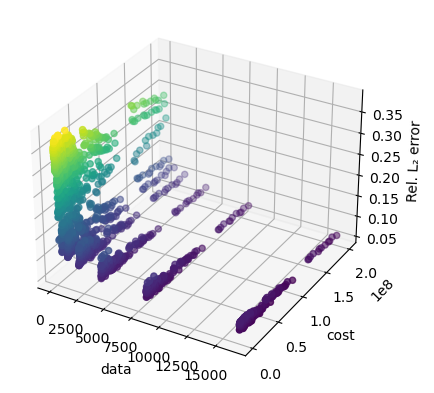

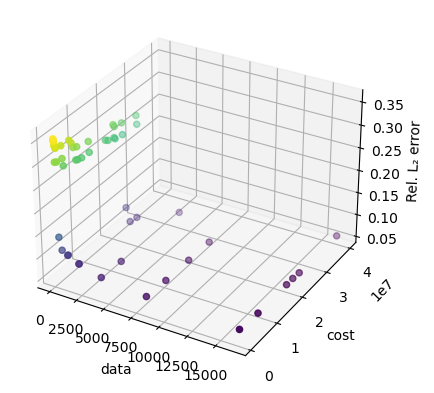

PyObject Text(0.10787434422876363, 0.014452421710067036, 'Rel. L₂ error')

In [24]:
# Cost/Data and error surface
# n_data, downsample_ratio, n_fno_layers, k_max, d_f
fno_data_size = data_analysis[:,1]
PyPlot.figure()
PyPlot.scatter3D(fno_data_size, fno_costs, fno_mean_rel_errors, c=fno_mean_rel_errors)
PyPlot.xlabel("data")
PyPlot.ylabel("cost")
PyPlot.zlabel("Rel. L₂ error")

###############################################################################
PyPlot.figure()
fno_data_size_pareto, fno_costs_pareto, fno_mean_rel_errors_pareto = [], [], []
for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_data_size_pareto = [fno_data_size_pareto;data_analysis_pareto[:,4]] 
    fno_costs_pareto = [fno_costs_pareto;data_analysis_pareto[:,3]]
    fno_mean_rel_errors_pareto = [fno_mean_rel_errors_pareto;data_analysis_pareto[:,2]]
    
end

PyPlot.scatter3D(fno_data_size_pareto, fno_costs_pareto, fno_mean_rel_errors_pareto, c=fno_mean_rel_errors_pareto)

PyPlot.xlabel("data")
PyPlot.ylabel("cost")
PyPlot.zlabel("Rel. L₂ error")

┌ Info: [0.4471224744422079, 0.20813011378140445, 1.448841302127319, 0.3733777512267247]
└ @ Main In[25]:15


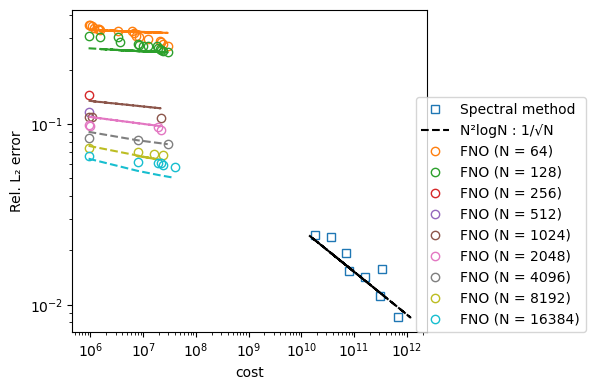

In [25]:
using LsqFit

# m(x, p) = p[1]./(x[:,1].^p[2])  +  p[3]./(x[:,2].^p[4])
# p0 = [1.0, 1.0, 1.0, 0.5]
# m(x, p) = (p[1]./(x[:,1].^p[2])  +  p[3]./(x[:,2].^min(p[4], 0.5))  +  p[5]./(x[:,1].^p[6].*x[:,2].^min(p[7], 0.5)) )
# p0 = [1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0]

m(x, p) = ( p[1]./(x[:,1].^p[2])  +  p[3]./(x[:,2].^min(p[4], 0.5))   )
p0 = [1.0, 1.0, 1.0, 0.4]


w = ones(length(fno_costs_pareto))
fit = curve_fit(m, [fno_costs_pareto fno_data_size_pareto fno_mean_rel_errors_pareto], fno_mean_rel_errors_pareto, w, p0)

@info fit.param

PyPlot.figure(figsize=(6,4))
# PyPlot.loglog(num_costs, num_mean_errors,           "-o", fillstyle = "none", label="FEM L₂ error")
PyPlot.loglog(num_costs, num_mean_rel_errors,       "s", fillstyle = "none", label="Spectral method")
N_unit = (1.0 ./ num_mean_rel_errors).^2
PyPlot.loglog(650*N_unit.^2 .* log.(N_unit), num_mean_rel_errors, "--", color = "black", label="N²logN : 1/√N")


for i = 1:n_d
    data_analysis_pareto = pareto_frontiers(data_analysis[1+n_g*(i-1):n_g*i,:], fno_mean_rel_errors[1+n_g*(i-1):n_g*i], fno_costs[1+n_g*(i-1):n_g*i])
    fno_costs_pareto, fno_mean_rel_errors_pareto, fno_data_size_pareto = data_analysis_pareto[:,3], data_analysis_pareto[:,2], data_analysis_pareto[:,4]
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto, "o", color = "C"*string(i), fillstyle = "none", label="FNO (N = $(n_data_array[i]))")
    
    fno_mean_rel_errors_pareto_fit = m([fno_costs_pareto fno_data_size_pareto], fit.param)
    PyPlot.loglog(fno_costs_pareto, fno_mean_rel_errors_pareto_fit, "--", color = "C"*string(i))
end
PyPlot.xlabel("cost")
PyPlot.ylabel("Rel. L₂ error")
PyPlot.legend(bbox_to_anchor=(0.95, 0.75))
PyPlot.tight_layout()
PyPlot.savefig("KS-cost-accuracy-fitting.pdf")
